In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [8]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [10]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [14]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [16]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

portfolio_name = cfg['portfolio']['name']
ticker_list = list(cfg['universe']['tickers'])

## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve
risk_min_signal = float(cfg['risk_and_sizing']['risk_min_signal'])
sleeve_risk_mode = str(cfg['risk_and_sizing']['sleeve_risk_mode']).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing']['risk_sleeve_budget_tolerance'])
risk_optimizer_step = float(cfg['risk_and_sizing']['risk_optimizer_step'])
risk_max_iterations = int(cfg['risk_and_sizing']['risk_max_iterations'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [18]:
ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'OXT-USD',
 'KRL-USD']

In [20]:
sleeve_budgets

{'L1_Core': {'weight': 0.5,
  'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
 'L1_Alt': {'weight': 0.15,
  'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
 'AI': {'weight': 0.35,
  'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}

In [22]:
print(risk_min_signal)
print(sleeve_risk_mode)
print(risk_sleeve_budget_tolerance)
print(risk_optimizer_step)
print(risk_max_iterations)

0.0001
cap
1e-05
0.5
100


In [71]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [73]:
start_date

datetime.date(2022, 4, 1)

In [75]:
end_date

datetime.date(2026, 1, 8)

## Expanded Universe Production Strategy

In [31]:
## Calculate a multiplier by date that when applied to the volatility adjusted signals, brings the
## risk contribution of each sleeve close to the allocated Risk Budget per sleeve
def risk_budget_by_sleeve_optimized_by_signal(signals, daily_cov_matrix, ticker_list, ticker_to_sleeve, sleeve_budgets,
                                              max_iter=100, tol=1e-5, step=0.5,
                                              min_signal_eps=1e-4,
                                              mode="cap" # "cap" = treat budgets as max, "target" = your current behaviour
                                             ):
    """
    signals: 1d np.array of base weights (vol-adjusted signals), length N
    daily_cov_matrix: NxN covariance matrix
    ticker_to_sleeve: dict {ticker: sleeve_name}
    sleeve_budgets:   dict {sleeve_name: {'weight': target_risk_share}}

    mode:
      - "cap": only reduce risk of sleeves whose risk_share > budget
      - "target": symmetric adjustment (your original behaviour)
    """
    ## Convert signals and covariance matrix to floating point numbers
    signals = np.asarray(signals, dtype=float)
    daily_cov_matrix = np.asarray(daily_cov_matrix, dtype=float)
    
    ## Get a list of all Sleeves in the Portfolio
    sleeves = list(sleeve_budgets.keys())

    ## Start with a Multiplier of 1 for Each Sleeve
    risk_multiplier = {s: 1.0 for s in sleeves}

    ## Identify active sleeves based on signal magnitude
    sleeve_signal_abs = {s: 0.0 for s in sleeves}
    for i, t in enumerate(ticker_list):
        s = ticker_to_sleeve[t]
        sleeve_signal_abs[s] += abs(signals[i])
    active_sleeves = {s for s in sleeves if sleeve_signal_abs[s] > min_signal_eps}

    ## If no sleeve has any signal, just return zeros
    if not active_sleeves:
        return np.zeros_like(signals, dtype=float), risk_multiplier

    ## If only one sleeve is active, no need for optimization – just use original signals
    if len(active_sleeves) == 1:
        return np.asarray(signals, dtype=float), risk_multiplier

    ## Renormalize budgets over active sleeves only (optional but helpful)
    total_budget_active = sum(sleeve_budgets[s]['weight'] for s in active_sleeves)
    eff_budget = {}
    for s in sleeves:
        if s in active_sleeves and total_budget_active > 0:
            eff_budget[s] = sleeve_budgets[s]['weight'] / total_budget_active
        else:
            eff_budget[s] = 0.0

    ## Iterate through to calculate the multiplier to minimize the max absolute error between the 
    ## allocated and actual risk budgets per sleeve
    for _ in range(max_iter):
        ## Build weights per ticker multiplying the vol adjusted signal with the current multiplier
        sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])

        ## If all signals are zero return
        if np.allclose(sleeve_risk_adj_weights, 0):
            return sleeve_risk_adj_weights, risk_multiplier

        ## Calculate the Portfolio Variance and Standard Deviaition for today given the current weights
        sigma2 = float(sleeve_risk_adj_weights @ daily_cov_matrix @ sleeve_risk_adj_weights)
        sigma = np.sqrt(sigma2)
        
        ## Calculate the Marginal Risk Contribution to Portfolio Risk
        ## This calculates the unit change in the portfolio volatility for a unit change in the weight of a coin
        ## This is essentially the first derivative of portfolio weight wrt signal weight w
        ## σ(w) = sqrt(w⊤Σw)
        ## ∂σ/∂w ​= 1 / (2*sqrt(w⊤Σw)) * 2Σw = Σw / σ​
        marginal_risk_unit = daily_cov_matrix @ sleeve_risk_adj_weights / sigma   # length N
        
        ## This calculates the risk contribution per coin
        ## This metric shows how much of the portfolio volatility comes from each coin in the portfolio
        ## Important Property: Sum of the risk contribution of all coins equals the portfolio volatility
        ## RCi ​= wi​ * marginali ​= wi​ * (Σw)i / σ
        risk_contribution_coin = sleeve_risk_adj_weights * marginal_risk_unit      # length N

        ## Calculate sleeve level volatility metrics and risk share
        ## RCs​ = i∈s∑ ​RCi​
        risk_contribution_sleeve = {s: 0.0 for s in sleeves}
        for i, t in enumerate(ticker_list):
            s = ticker_to_sleeve[t]
            risk_contribution_sleeve[s] += risk_contribution_coin[i]

        ## Calculate percent of risk contribution per sleeve or risk share
        ## s∑​risk_shares ​= 1/σ * ∑​RCs ​= 1/σ * ​i∑​RCi ​= 1
        risk_share_sleeve = {s: risk_contribution_sleeve[s] / sigma for s in sleeves}

        ## Calculate the maximum absolute difference between actual risk share per sleeve and desired risk budget
        ## If the maximum absolute difference is below the tolerance threshold, we exit and keep the calculated multiplier
        # risk_allocation_error = max(abs(risk_share_sleeve[s] - sleeve_budgets[s]['weight']) for s in sleeves)
        risk_allocation_error = max(abs(risk_share_sleeve[s] - eff_budget[s]) for s in active_sleeves)
        if risk_allocation_error < tol:
            break

        ## Multiplicative Update: 
        ## If a sleeve has too much risk, we shrink its multiplier
        ### For too much risk, desired risk budget / actual risk per sleeve is less than 1
        ### We square this fraction by the step leading to a smaller multiplier for the next iteration
        
        ## If a sleeve has too little risk, we grow its multiplier
        ### For too little risk, desired risk budget / actual risk per sleeve is greater than 1
        ### We square this fraction by the step leading to a larger multiplier for the next iteration
        for s in active_sleeves:
            rs = risk_share_sleeve[s]
            b = eff_budget[s]
            if rs <= 0:
                continue

            if mode == 'target':
                ratio = b / rs
                risk_multiplier[s] *= ratio ** step

            elif mode == 'cap':
                ## only shrink sleeves that are ABOVE their budget
                if rs > b and b > 0:
                    ratio = b / rs
                    risk_multiplier[s] *= ratio ** step
                ## if rs <= b, leave multiplier unchanged (don't lever up weak sleeves)

    ## Final Sleeve Risk Adjusted Weights
    sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]]
                                        for i, t in enumerate(ticker_list)], dtype=float)
    
    return sleeve_risk_adj_weights, risk_multiplier

In [33]:
def get_target_volatility_daily_portfolio_positions_with_risk_multiplier_sleeve_weights_opt(df, ticker_list, initial_capital, rolling_cov_window,
                                                                                            stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                                            highest_high_window, cash_buffer_percentage,
                                                                                            annualized_target_volatility, transaction_cost_est=0.001,
                                                                                            passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                                            min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                                            annual_trading_days=365, use_specific_start_date=False,
                                                                                            signal_start_date=None, ticker_to_sleeve=None,
                                                                                            sleeve_budgets=None, risk_max_iterations=None, risk_sleeve_budget_tolerance=None,
                                                                                            risk_optimizer_step=None, risk_min_signal=None, sleeve_risk_mode=None):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_sleeve_risk_multiplier'] = 0.0
        df[f'{ticker}_sleeve_risk_adj_weights'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                           total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets,
                                                                                           risk_max_iterations, risk_sleeve_budget_tolerance,
                                                                                           risk_optimizer_step, risk_min_signal, sleeve_risk_mode)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [35]:
def get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                  total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets, risk_max_iterations, risk_sleeve_budget_tolerance,
                                                                                  risk_optimizer_step, risk_min_signal, sleeve_risk_mode):

    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    sleeve_risk_multiplier_cols = [f'{ticker}_sleeve_risk_multiplier' for ticker in ticker_list]
    sleeve_risk_adj_cols = [f'{ticker}_sleeve_risk_adj_weights' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
    
    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights, sleeve_risk_multiplier = risk_budget_by_sleeve_optimized_by_signal(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
            max_iter=risk_max_iterations,
            tol=risk_sleeve_budget_tolerance,
            step=risk_optimizer_step,
            min_signal_eps=risk_min_signal,
            mode=sleeve_risk_mode
        )
        sleeve_risk_multiplier = np.array(
            [float(sleeve_risk_multiplier.get(ticker_to_sleeve[t], 1.0)) for t in ticker_list],
            dtype=float
        )
    else:
        rb_weights = daily_weights.copy()
        sleeve_risk_multiplier = np.ones(len(ticker_list))
    rb_weights = np.asarray(rb_weights, dtype=float)
    rb_weights = np.clip(rb_weights, 0.0, None)
    sleeve_risk_multiplier = np.asarray(sleeve_risk_multiplier, dtype=float)
    df.loc[date, sleeve_risk_adj_cols] = rb_weights
    df.loc[date, sleeve_risk_multiplier_cols] = sleeve_risk_multiplier
    
    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df
        
    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [37]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
    log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
    r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
    long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
    volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
    highest_high_window=56, transaction_cost_est=0.001,
    passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
    use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
    cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
    use_specific_start_date=False, signal_start_date=None, sleeve_budgets=None, risk_max_iterations=None,
    risk_sleeve_budget_tolerance=None, risk_optimizer_step=None, risk_min_signal=None, sleeve_risk_mode=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    # cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
    # sleeve_budgets = cfg_v2['universe']['sleeves']
    ticker_to_sleeve = {}
    for sleeve in sleeve_budgets.keys():
        print(sleeve)
        sleeve_tickers = sleeve_budgets[sleeve]['tickers']
        for ticker in sleeve_tickers:
            ticker_to_sleeve[ticker] = sleeve
    
    df = get_target_volatility_daily_portfolio_positions_with_risk_multiplier_sleeve_weights_opt(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        ticker_to_sleeve=ticker_to_sleeve, sleeve_budgets=sleeve_budgets, risk_max_iterations=risk_max_iterations,
        risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance, risk_optimizer_step=risk_optimizer_step,
        risk_min_signal=risk_min_signal, sleeve_risk_mode=sleeve_risk_mode)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [39]:
def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_notional_t_1 = pos_prev_all.abs().sum(axis=1)
    total_net_notional_t_1 = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_value_t_1 = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_t_1"] = np.where(
        total_portfolio_value_t_1 > 0,
        total_net_notional_t_1 / total_portfolio_value_t_1,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        sleeve_ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        sleeve_pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        sleeve_notionals_t_1 = df[sleeve_pos_cols].shift(1)                ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_notional_t_1 = sleeve_notionals_t_1.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_net_notional_t_1 = sleeve_notionals_t_1.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (sleeve_notionals_t_1.values * df[sleeve_ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_notional_t_1.values > 0,
            sleeve_pnl / sleeve_gross_notional_t_1.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_notional_t_1

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_notional_t_1.values > 0,
            sleeve_gross_notional_t_1.values / total_gross_notional_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_value_t_1.values > 0,
            sleeve_net_notional_t_1.values / total_portfolio_value_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df

import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")

In [78]:
df_expanded_universe = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [79]:
# ----- 2) cut warmup -----
df_expanded_universe = df_expanded_universe[df_expanded_universe.index >= pd.Timestamp(start_date)]

# ----- 3) add asset-level + portfolio returns -----
df_expanded_universe = perf.calculate_asset_level_returns(df_expanded_universe, end_date, ticker_list)

# ----- 4) portfolio-level metrics -----
port_metrics = calculate_risk_and_performance_metrics(
    df_expanded_universe,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
port_metrics.update({
    "w_core": sleeve_budgets['L1_Core']['weight'],
    "w_alt":  sleeve_budgets['L1_Alt']['weight'],
    "w_ai":   sleeve_budgets['AI']['weight'],
})

# ----- 5) sleeve-level metrics -----
sleeves_to_tickers = {}
for k, v in sleeve_budgets.items():
    sleeves_to_tickers[k] = v['tickers']

target_risk_budget = {
    "L1_Core": float(np.round(sleeve_budgets['L1_Core']['weight'], 2)),
    "L1_Alt":  float(np.round(sleeve_budgets['L1_Alt']['weight'], 2)),
    "AI":      float(np.round(sleeve_budgets['AI']['weight'], 2)),
}
df_sleeves = add_sleeve_series(
    df_expanded_universe,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    budget_band=0.20,
    strategy_trade_count_col="count_of_positions",
)

sleeve_metrics = summarize_sleeves_with_user_metrics(
    df_sleeves,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_rf=0.05,
    annual_trading_days=annual_trading_days,
)

# tag the run weights on the sleeve table too
sleeve_metrics["w_core"] = sleeve_budgets['L1_Core']['weight']
sleeve_metrics["w_alt"]  = sleeve_budgets['L1_Alt']['weight']
sleeve_metrics["w_ai"]   = sleeve_budgets['AI']['weight']

In [80]:
port_metrics

{'annualized_return': 0.2653087703160688,
 'annualized_sharpe_ratio': 0.9891458545336791,
 'calmar_ratio': 1.3175806200754696,
 'annualized_std_dev': 0.493680418135813,
 'max_drawdown': -0.20136055909874584,
 'max_drawdown_duration': Timedelta('397 days 00:00:00'),
 'hit_rate': 0.12835387962291517,
 't_statistic': 2.373927210870177,
 'p_value': 0.01773641316906379,
 'trade_count': 268.0,
 'w_core': 0.5,
 'w_alt': 0.15,
 'w_ai': 0.35}

In [81]:
sleeve_metrics

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_ai
sleeve,,,,,,,,,,,,,,,,,,,
L1_Core,0.107871,0.625983,1.172726,0.195896,-0.091984,371 days,0.114576,2.242518,0.025086,304,0.207140,0.0,1.000000,0.50,-0.292860,0.015228,0.5,0.15,0.35
L1_Alt,0.010299,-1.212539,0.241142,0.142965,-0.042710,629 days,0.023205,0.664854,0.506255,67,0.022104,0.0,0.142256,0.15,-0.127896,0.013778,0.5,0.15,0.35
AI,0.041828,-0.032752,0.415567,0.394672,-0.100654,663 days,0.028281,0.905221,0.365506,85,0.033265,0.0,0.268092,0.35,-0.316735,0.013778,0.5,0.15,0.35


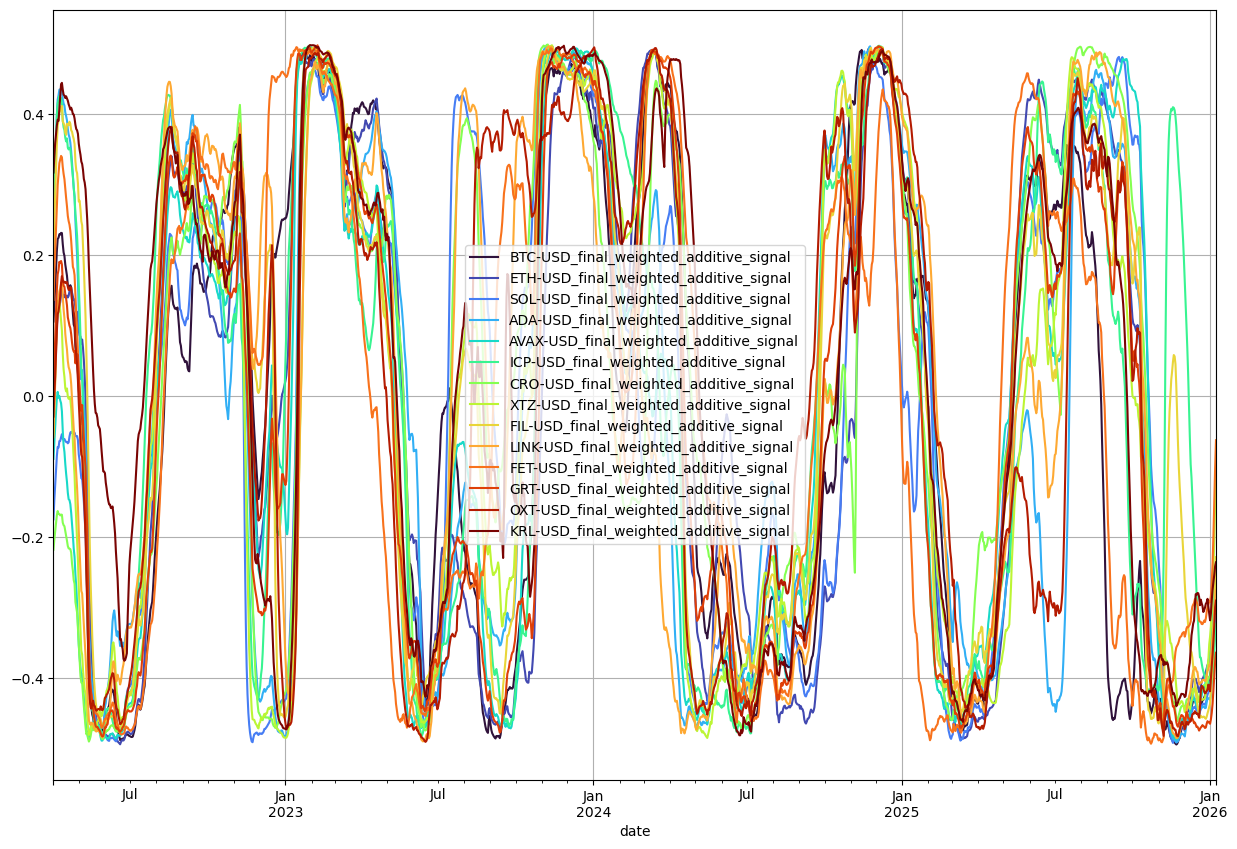

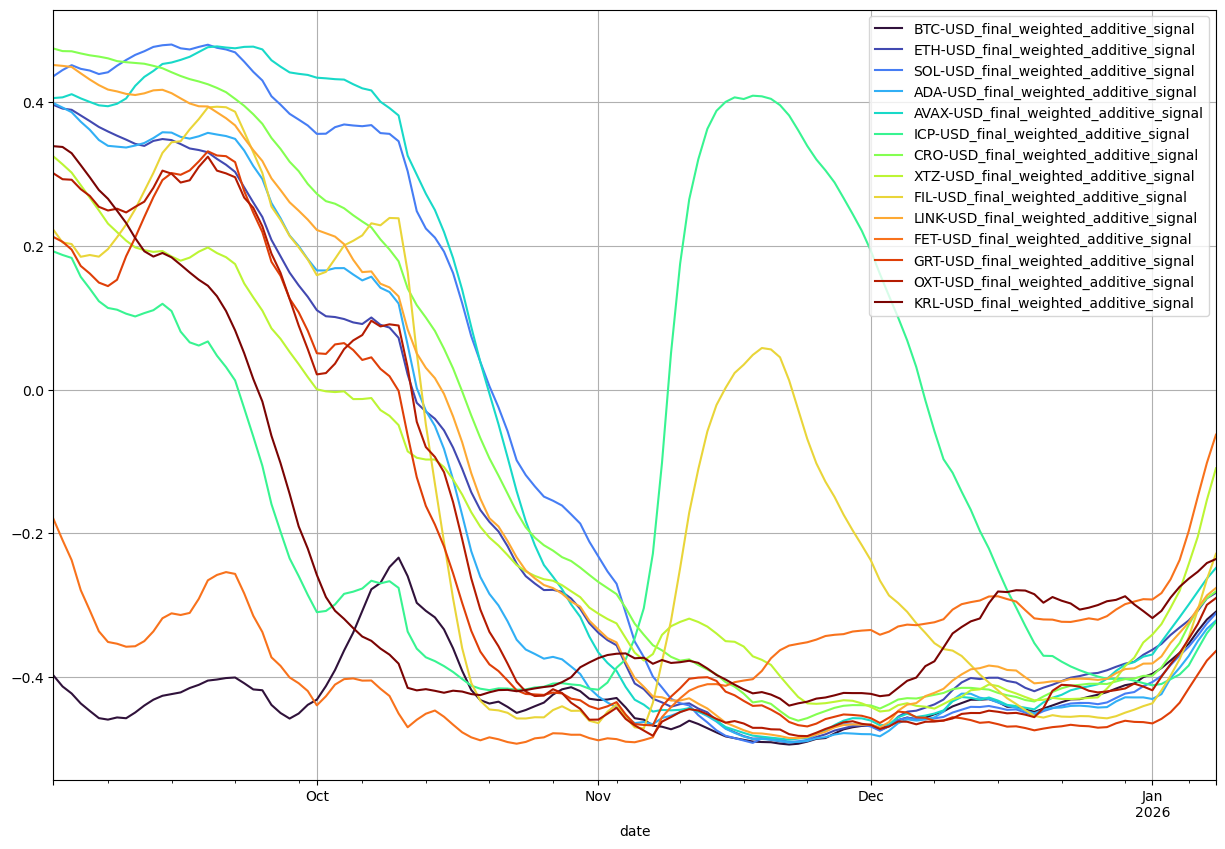

In [86]:
import matplotlib.pyplot as plt
import numpy as np

raw_signal_cols = [f'{t}_final_weighted_additive_signal' for t in ticker_list]
date_cond = df_expanded_universe.index > pd.Timestamp('2025-09-01')

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(raw_signal_cols)))

df_expanded_universe[raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()


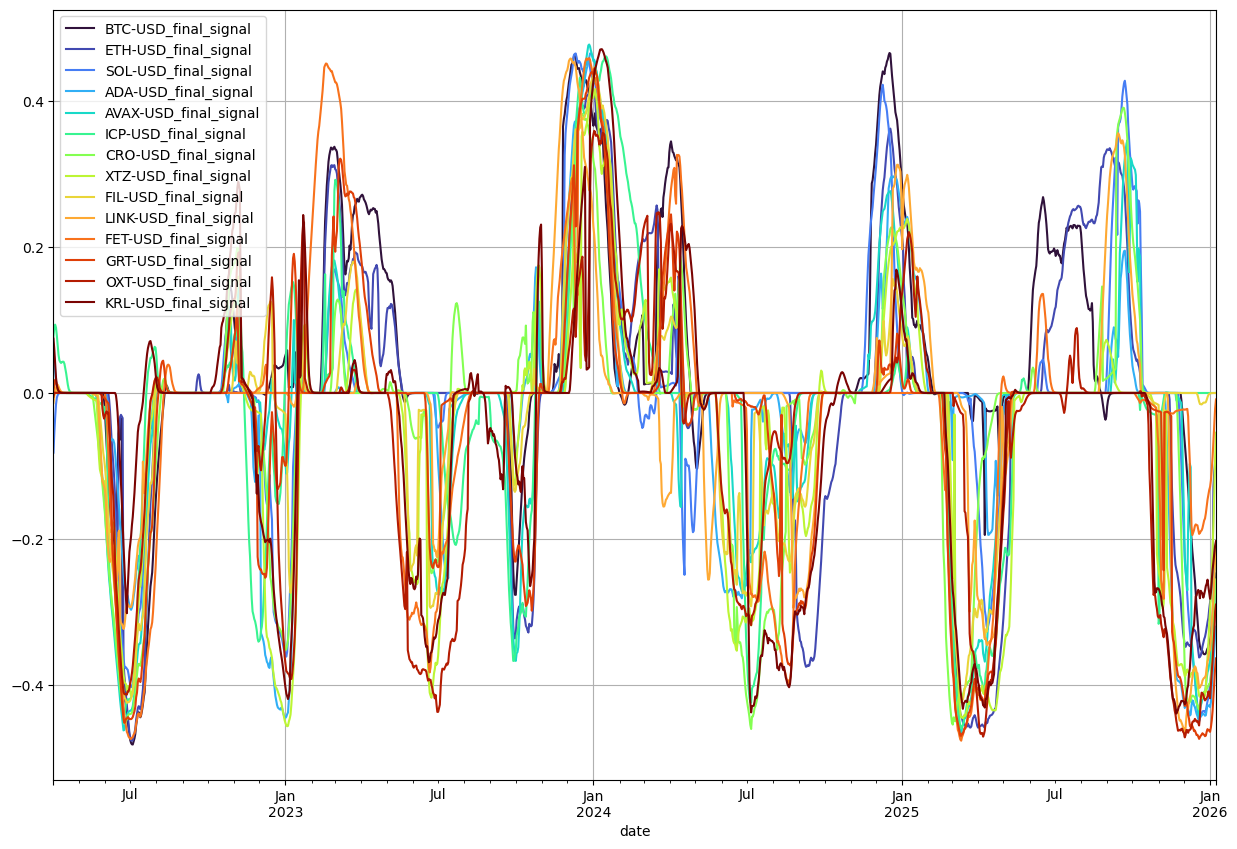

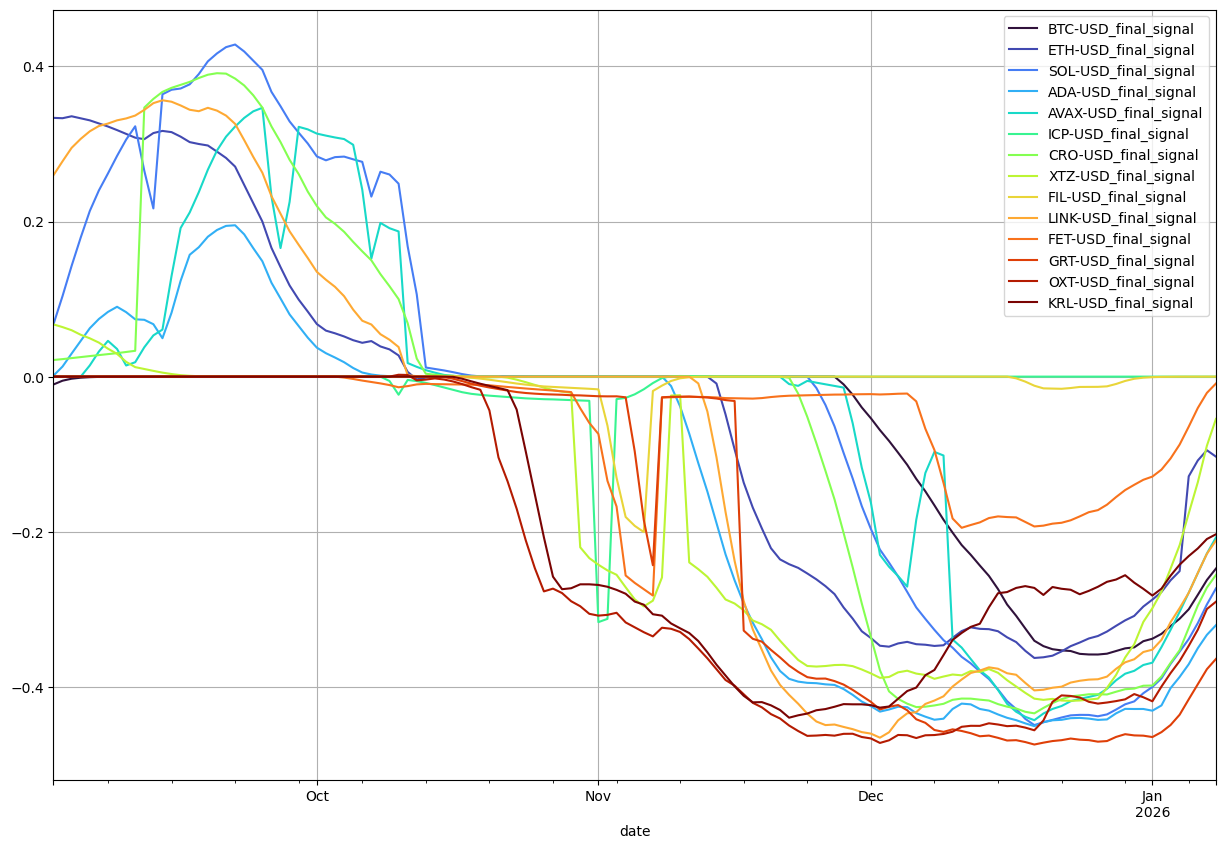

In [87]:
## Signal after Regime Filtering and Before Volatility Adjusting
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe[final_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, final_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()

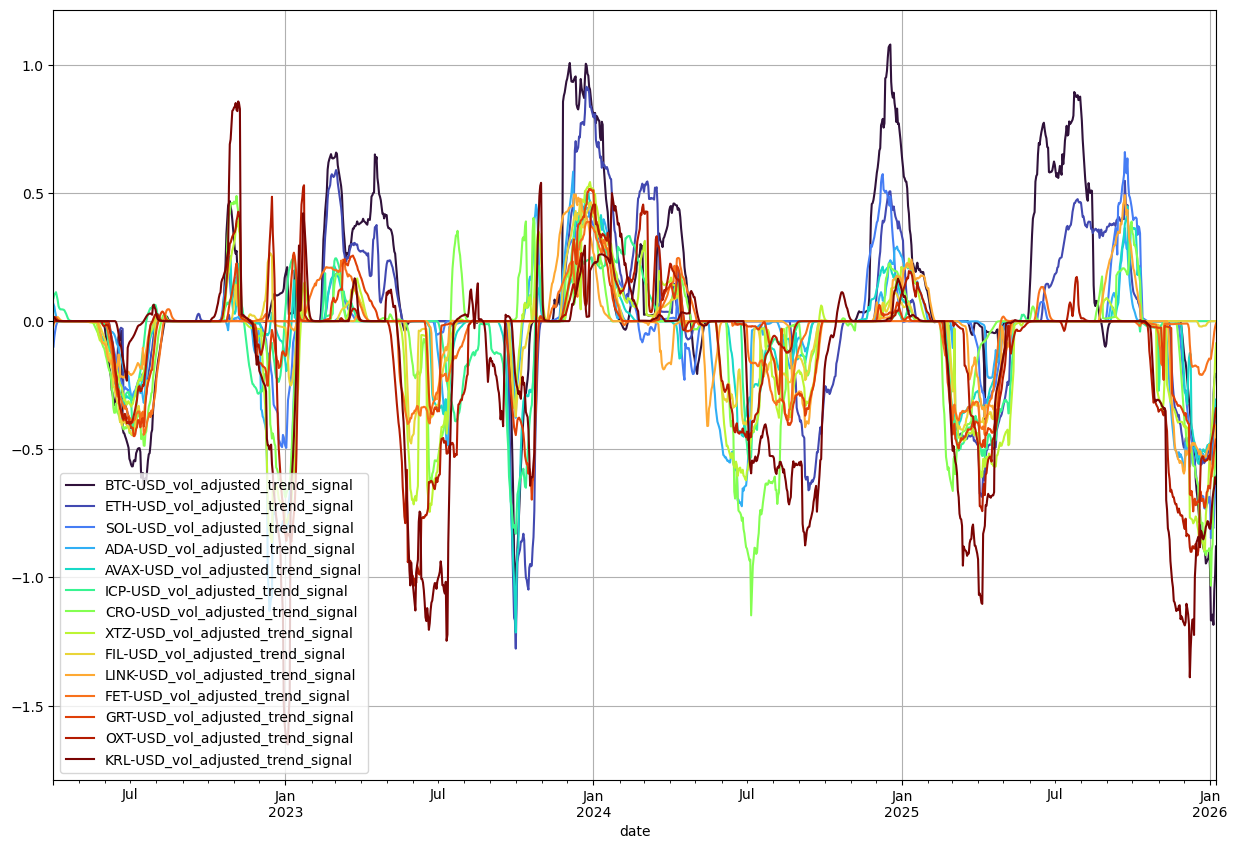

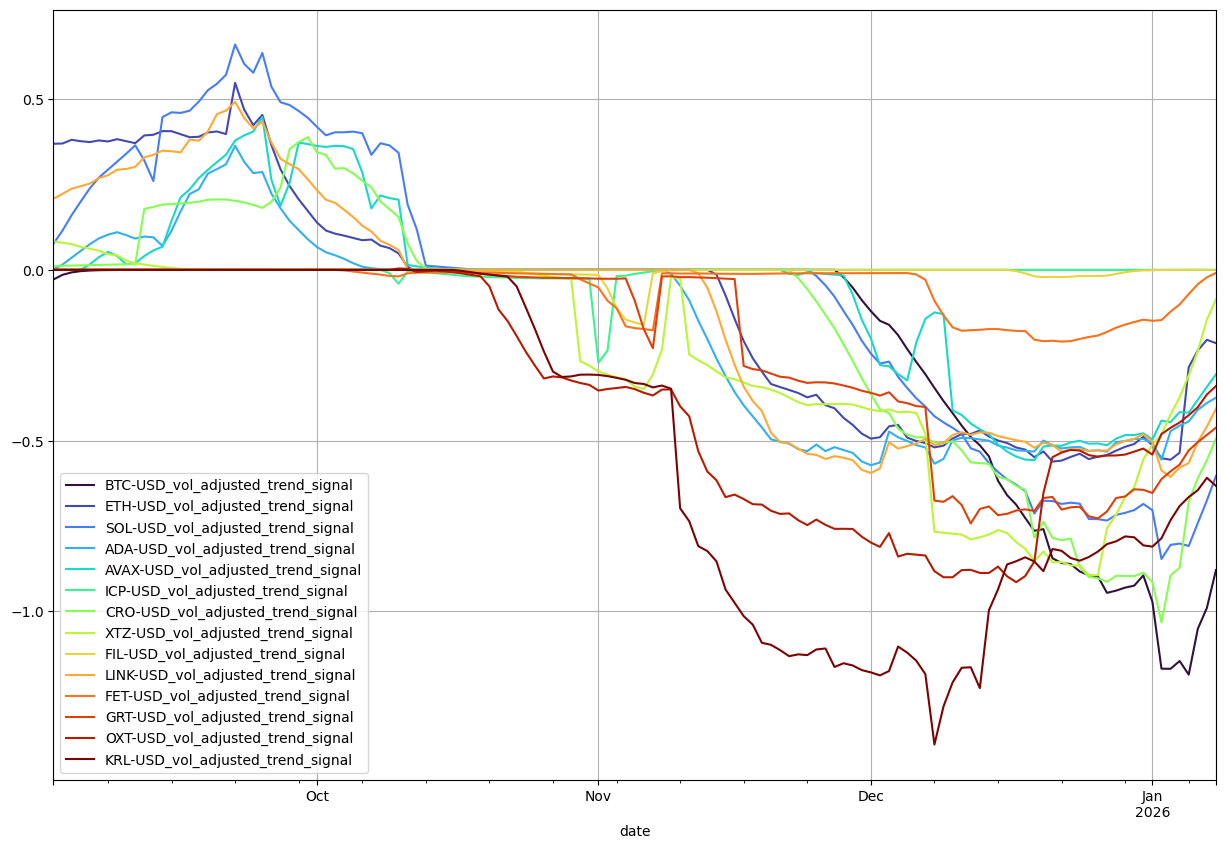

In [88]:
## Signal after Volatility Adjusting
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe[vol_adj_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, vol_adj_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()

<Axes: xlabel='date'>

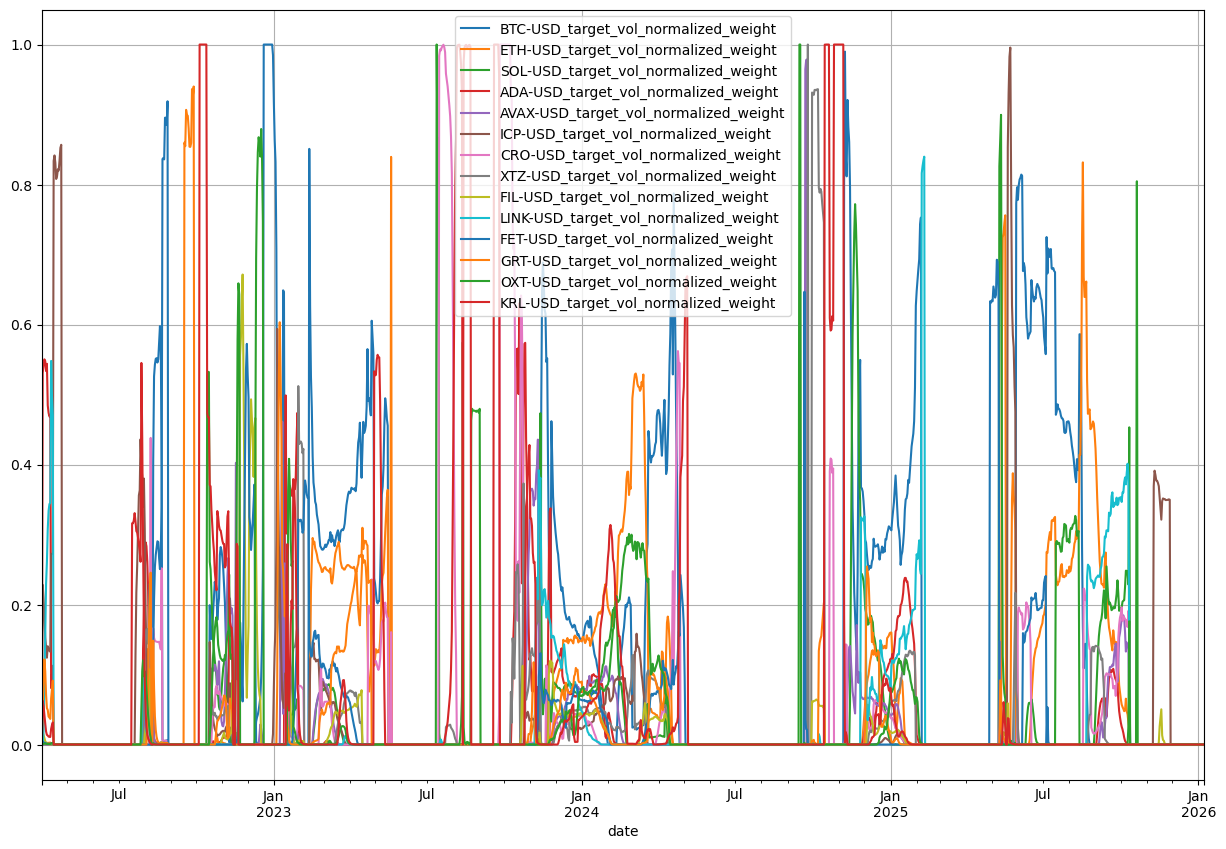

In [89]:
## Signal After Scaling for Cash, Risk Budgets and Target Volatility
target_vol_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))
df_expanded_universe[target_vol_signal_cols].plot(figsize=(15,10), grid=True)

In [91]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                            portfolio_name=portfolio_name)

In [93]:
current_positions

{'BTC-USD': {'ticker_qty': 0,
  'ticker_mid_price': 91016.955,
  'ticker_current_notional': 0.0},
 'ETH-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3161.245,
  'ticker_current_notional': 0.0},
 'SOL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 137.165,
  'ticker_current_notional': 0.0},
 'ADA-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.40145,
  'ticker_current_notional': 0.0},
 'AVAX-USD': {'ticker_qty': 0,
  'ticker_mid_price': 14.114999999999998,
  'ticker_current_notional': 0.0},
 'ICP-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3.2225,
  'ticker_current_notional': 0.0},
 'CRO-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.10366500000000001,
  'ticker_current_notional': 0.0},
 'XTZ-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.5674999999999999,
  'ticker_current_notional': 0.0},
 'FIL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 1.5110000000000001,
  'ticker_current_notional': 0.0},
 'LINK-USD': {'ticker_qty': 0,
  'ticker_mid_price': 13.4545,
  'ticker_current_notional

In [94]:
portfolio_equity, available_cash = cn.get_live_portfolio_equity_and_cash(client=client,
                                                                         portfolio_name=portfolio_name)

In [95]:
portfolio_equity

0.0

In [97]:
available_cash

1025.5554260000001

In [99]:
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name)
df_portfolio_positions = cn.get_portfolio_breakdown(client, portfolio_uuid)

In [100]:
df_portfolio_positions

,asset,account_uuid,asset_uuid,total_balance_fiat,available_to_trade_fiat,total_balance_crypto,allocation,cost_basis_value,cost_basis_currency,is_cash,average_entry_price_value,average_entry_price_currency,available_to_trade_crypto,unrealized_pnl,available_to_transfer_fiat,available_to_transfer_crpyto
0,USD,7ebde10b-30e9-5200-aea2-000837e4dcc5,,45.148426,45.148426,45.148426,0.044023,45.1484261114496,USD,True,1,USD,45.148426,0,45.148426,45.148426
1,USDC,df272673-0459-5445-8f90-eaebabe73a6e,2b92315d-eab7-5bef-84fa-089a131333f5,980.407000,980.407000,980.407000,0.955977,980.4069597271814993,USD,True,1,USD,980.407000,0,980.407000,980.407000
